# Exploring Applicability of NN to Neutron/Gamma Discrimination Task

In [2]:
# general imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import io
import re

# model building
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Bidirectional, InputLayer, SimpleRNN, Dropout, Flatten, Conv1D, Input, MaxPooling1D, Embedding
from keras.optimizers import RMSprop
from keras.callbacks import LambdaCallback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import np_utils
from keras import backend as K

# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


### Data Preparation

In [0]:
# load voltage data
vpath = '/content/drive/My Drive/RESEARCH/NG_DISCRIMINATION/psd/data/PuBe/PuBe_OLS.txt'
with open(vpath, 'r') as file:
  text = file.read()

In [0]:
# extract voltage values
pattern = r"^\d+$"
raw_energies = re.findall(pattern, text, re.MULTILINE)

# break into numpy array with sequences of 136 voltages
record_length = 136
num_events = int(len(raw_energies)/record_length)
energies = np.zeros([num_events, record_length])
k = 0 # for indexing raw_voltages
adc = 12 # 2 ^ adc describes the range of potential energy values

for i in range(num_events):
  for j in range(record_length):
    energies[i][j] = float(raw_energies[k])/(2**(adc) - 1) # save energies normalized against potential voltage range
    k+=1

In [0]:
# standard normalization
for i in range(len(energies)):
  mean = energies[i].mean(axis = 0)
  energies -= mean
  std = energies[i].std(axis = 0)
  energies /= std

In [0]:
# load labels
lpath = '/content/drive/My Drive/RESEARCH/NG_DISCRIMINATION/psd/data/PuBe/PuBe_Truth.txt'
with open(lpath, 'r') as file:
  text = file.read()

In [0]:
# extract label values
pattern = r"(N|G|U)"
raw_labels = re.findall(pattern, text, re.MULTILINE)
labels = np.asarray(raw_labels)

In [0]:
# remove unknown labels
raw_labels_noU = []
rows_to_delete = [] # for deleting unknown sequences in energies
for i in range(len(raw_labels)):
  if raw_labels[i] != 'U':
    raw_labels_noU.append(raw_labels[i])
  else:
    rows_to_delete.append(i)

In [0]:
# delete corresponding sequences that were classified unknown
energies = np.delete(energies, rows_to_delete, axis = 0) 

In [0]:
# calculate deltas as another feature
deltas = np.zeros(energies.shape)
for i in range(len(energies)):
  for j in range(1, record_length):
    deltas[i][j] = energies[i][j] - energies[i][j-1]

In [0]:
# depth stack energies and deltas into one tensor
x = np.dstack((energies, deltas))

In [0]:
# convert labels to 0.0/1.0
y = []
for i in range(len(raw_labels_noU)):
  if labels[i] == 'N':
    y.append(1.0)
  else:
    y.append(0.0)
y = np.asarray(y)

In [13]:
# verify shape of x & y
print(x.shape, y.shape)

(13616, 136, 2) (13616,)


In [15]:
# create model
model = Sequential()
model.add(Dense(8, input_shape = (136, 2,)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 136, 8)            24        
_________________________________________________________________
dense_4 (Dense)              (None, 136, 1)            9         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Early Stopping Callback
es_cb = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5, min_delta = .001, restore_best_weights=True)

# Model Checkpoint Callback 
# filepath = 'weights.hdf5'
# mc_cb = ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')

# callback list
cb_list = [es_cb]

In [17]:
# fit model
history = model.fit(x, y, batch_size = 32, epochs = 100, validation_split = 0.2, verbose = 1, callbacks = cb_list, shuffle = True)

ValueError: ignored

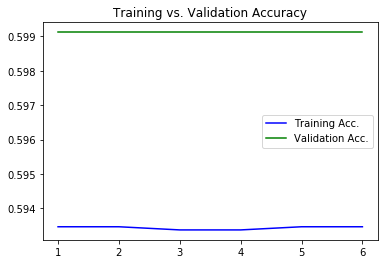

Maximum Validation Accuracy Achieved: 0.5991189427312775


In [0]:
# Plot test/val accuracy
acc = history.history['acc']
vacc = history.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training Acc.')
plt.plot(epochs, vacc, 'g', label = 'Validation Acc.')
plt.title ('Training vs. Validation Accuracy')
plt.legend()
plt.show()

print('Maximum Validation Accuracy Achieved: ' + str(max(history.history['val_acc'])))